#10. 도로 영역을 찾자! - 세그멘테이션 모델 만들기

## 10-1) 시멘틱 세그멘테이션 데이터셋

In [17]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [3]:
!pip list | grep albumentations

albumentations                0.1.12


In [85]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

기본적인 어그멘테이션을 해준다. 

매번 라이브러리가 달라져서 힘듬 ㅠㅠ

albumentations 라이브러리는 2020년에 나온 라이브러리로

다른 augmentation 라이브러리와 비교해서 2배 이상 빨라서 좋다고 한다.

여기서는 좌우 대칭, 랜덤 사이즈 crop을 통해서 어그멘테이션을 해주었고

중요한건 입출력 크기를 224,224,3 맞춰주는 것이라 볼 수 있겠다.

In [84]:
%cd /content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/Sementic_Segmantation
#!unzip -qq "/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/Sementic_Segmantation/aaa.zip"

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/Sementic_Segmantation


In [86]:
dir_path = os.getcwd()+'/data/training'
print(dir_path)

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/Sementic_Segmantation/data/training


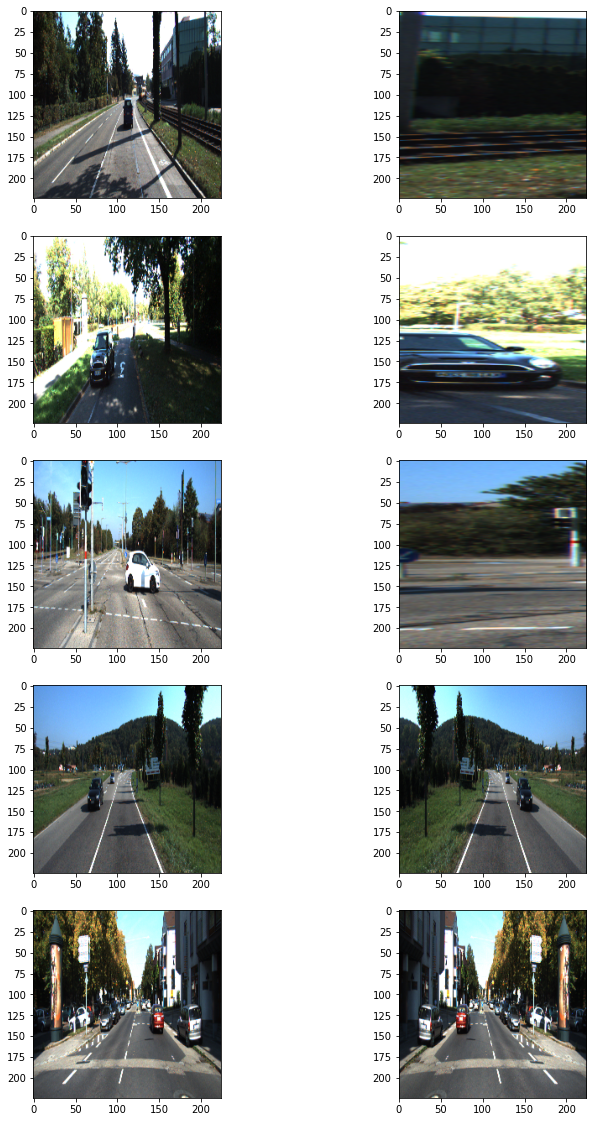

In [87]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)      # 5행 2열 총 5x2에서 i(인덱스 0에서 부터 시작)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

다소 늘어나거나 세부정보만 남기도 하지만 큰 문제 안될 듯

In [9]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

제너레이터나 클래스의 개념을 확실히 모르니 대충 이해하기로는

랜덤하게 배치 사이즈만큼 training set과 label set을 가져온담에

순서를 매겨서 차례대로 읽어오게 하는 것 같다.

언제나 그렇듯 input과 output은 [batch size, w, h, c]로 구성되는데 

여기서는 도로만 파악하면되므로, 도로인 값들만 뽑아서 레이블을 구성하는 것을 볼 수 있다.


In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 10-2) 시맨틱 세그멘테이션 모델

In [52]:
 def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    '''
    3x3 conv 두번 + 2x2 max pooling 한 번의 사이클 통해 
    feature map의 크기는 점점 작아지고 채널은 2배로 늘어난다.
    conv에서도 패딩안해주는 경우도 있다고 하지만 일단 여기서는 크기를 맞춰줬고
    relu를 통해 음수 패러미터 삭제,
    원활한 학습을 통해 가중치 초기화를 'he_normal'을 사용해서 해준 것을 볼 수 있다.
    위와 같은 사이클을 5번 반복해서 down-sampling을 해주는 것 같다.
    '''

    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    '''
    drop out은 학습 성능 증가를 위해서 해준것으로 보임
    '''

    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    
    '''
    수축과정에서 10번의 conv를 거쳤고 여기서 얻은 채널들을 
    같은 크기를 가지는 확장 Path에서 뒤쪽 conv에 concat해주면 된다.
    padding을 통해 입출력 크기의 변동이 없으므로 이미지를 crop할 필요는 없을 것 같다.
    '''

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    '''
    Transpose과정은 maxpooling의 역연산(?)에 해당하므로 그림을 압축시키면서 사라진 정보를 되돌려준다.
    또한 같은 크기를 가지는 앞 쪽 연산을 concat해준다.
    출력값의 사이즈는 (,가로픽셀,세로픽셀,특성채널) 맨 앞 차원은 batch와 관련된 차원이므로 axis =3에 붙여준걸 볼 수 있다.)
    '''
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    '''
    예시에는 시그모이드로 되어있는데, 아마도 클래스가 2개가 아니기 때문에 소프트맥스로 바꿔주어야 할꺼 같다.
    안되면 다시 되돌리지뭐
    '''
 
    model = Model(inputs = inputs, outputs = conv10)
    return model

In [53]:
model_path = '/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/Sementic_Segmantation'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)

Epoch 1/100
11/11 [==============================] - 8s 626ms/step - loss: 0.6834 - val_loss: 0.6598
Epoch 2/100
11/11 [==============================] - 7s 600ms/step - loss: 0.5585 - val_loss: 0.1260
Epoch 3/100
11/11 [==============================] - 7s 591ms/step - loss: 0.0514 - val_loss: 0.0415
Epoch 4/100
11/11 [==============================] - 6s 587ms/step - loss: 0.0398 - val_loss: 0.0354
Epoch 5/100
11/11 [==============================] - 6s 587ms/step - loss: 0.0347 - val_loss: 0.0315
Epoch 6/100
11/11 [==============================] - 6s 589ms/step - loss: 0.0282 - val_loss: 0.0272
Epoch 7/100
11/11 [==============================] - 6s 591ms/step - loss: 0.0349 - val_loss: 0.0383
Epoch 8/100
11/11 [==============================] - 7s 593ms/step - loss: 0.0346 - val_loss: 0.0278
Epoch 9/100
11/11 [==============================] - 7s 593ms/step - loss: 0.0322 - val_loss: 0.0296
Epoch 10/100
11/11 [==============================] - 7s 593ms/step - loss: 0.0298 - val_lo

## 10-3) 시맨틱 세그멘테이션 모델 시각화

In [90]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [93]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.40).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 

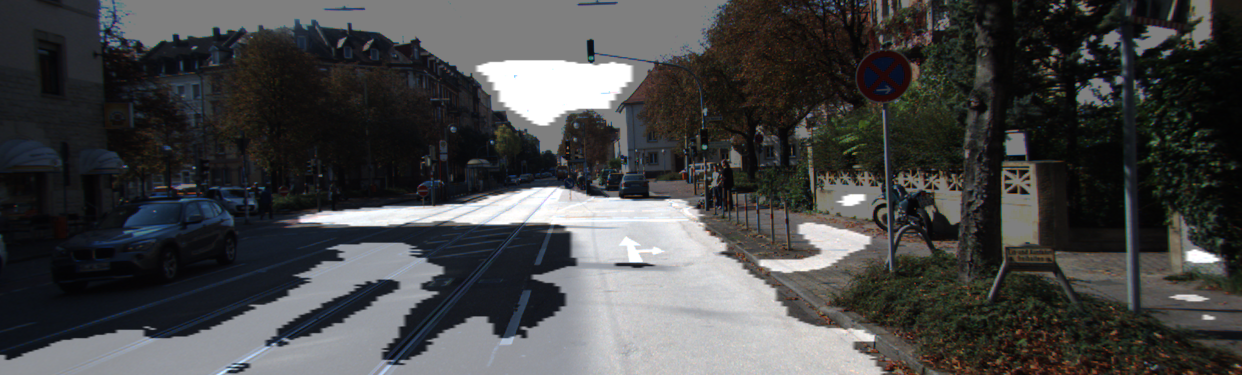

In [94]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [95]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [96]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [98]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

## 여기서부터 실습
## 10.4) 프로젝트 : 개선된 U-Net 모델 만들기


### 10.4.1) KITTI 데이터셋 수집과 구축

In [4]:
import os
import cv2
from collections import OrderedDict
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Input, merge, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras import optimizers
from keras.regularizers import l2
from keras.layers.noise import GaussianDropout

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

일단 데이터셋 입력은 원래방식과 동일하게 가보자

In [5]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [99]:
%cd /content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/Sementic_Segmantation

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/Sementic_Segmantation


In [100]:
dir_path = os.getcwd()+'/data/training'
print(dir_path)

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/Sementic_Segmantation/data/training


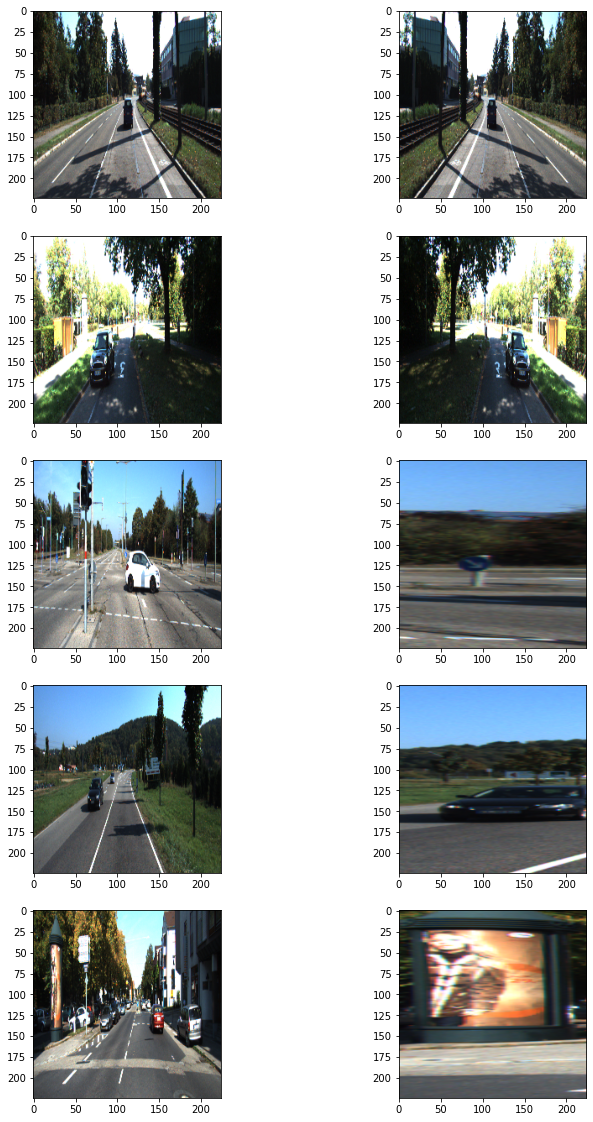

In [101]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [10]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [11]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### 10.4.2) U-Net++ 모델의 구현

In [103]:
def build_model_2(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    #1.1부터 앞쪽이 넘어갈때는 pool을 거치고 순차적으로 진행됨
    conv11 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv11 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv11)

    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)

    conv21 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool11)
    conv21 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv21)

    pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
    # up방향은 이전 conv레벨을 같이 concat해주는 방향으로
    up12 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv21)
    merge12 = concatenate([up12, conv11], axis = 3)
    conv12 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge12)
    conv12 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv12)

    conv31 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool21)
    conv31 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv31)

    pool31 = MaxPooling2D(pool_size=(2, 2))(conv31)

    up22 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv31)
    merge22 = concatenate([up22, conv21], axis = 3)
    conv22 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge22)
    conv22 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv22)    

    up13 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv22)
    merge13 = concatenate([up13, conv11, conv12], axis = 3)
    conv13 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge13)
    conv13 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv13)

    conv41 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool31)
    conv41 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv41)

    pool41 = MaxPooling2D(pool_size=(2, 2))(conv41)

    up32 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv41)
    merge32 = concatenate([up32, conv31], axis = 3)
    conv32 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge32)
    conv32 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv32)

    up23 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv32)
    merge23 = concatenate([up23, conv21, conv22], axis = 3)
    conv23 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge23)
    conv23 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv23) 

    up14 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv23)
    merge14 = concatenate([up14, conv11, conv12, conv13], axis = 3)
    conv14 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge14)
    conv14 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv14) 

    conv51 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool41)
    conv51 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv51)

    up42 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv51)
    merge42 = concatenate([up42, conv41], axis = 3)
    conv42 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge42)
    conv42 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv42)

    up33 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv42)
    merge33 = concatenate([up33, conv31, conv32], axis = 3)
    conv33 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge33)
    conv33 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv33)

    up24 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv33)
    merge24 = concatenate([up24, conv21, conv22, conv23], axis = 3)
    conv24 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge24)
    conv24 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv24)

    up15 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv24)
    merge15 = concatenate([up15, conv11, conv12, conv13, conv14], axis = 3)
    conv15 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge15)
    conv15 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv15)

    output1 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv12)
    output2 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv13)
    output3 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv14)
    output4 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv15)

    # model = Model(inputs = inputs, outputs = (output1+output2+output3+output4)/4)
    # 결과값을 로스함수 거치기 전에 산술평균으로 앙상블하면 학습이 정상적으로 진행되지 않았다.
    # 로스함수를 지난 뒤 합쳐지는 방식으로 다시 해봐야 할꺼같다.
    model = Model(inputs = inputs, outputs = [output1, output2, output3, output4])

    return model

In [104]:
smooth = 1.

# Custom loss function
loss_list = []
def dice_coef(y_true, y_pred):
    for i in y_pred:
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(i)
        intersection = K.sum(y_true_f * y_pred_f)
        a = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        loss_list.append(a)
    return loss_list

def bce_dice_loss(y_true, y_pred):
    loss_sum = 0
    for i in loss_list:
        losses = 0.5 * keras.losses.binary_crossentropy(y_true, i) - dice_coef(y_true, i)
        loss_sum += losses
    return loss_sum/4


In [61]:
model = build_model_2()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_69 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_68[0][0]']              
                                )                                                           

In [105]:
model.compile(optimizer = Adam(1e-4), loss = bce_dice_loss)
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100


ValueError: ignored

In [80]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.50).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 

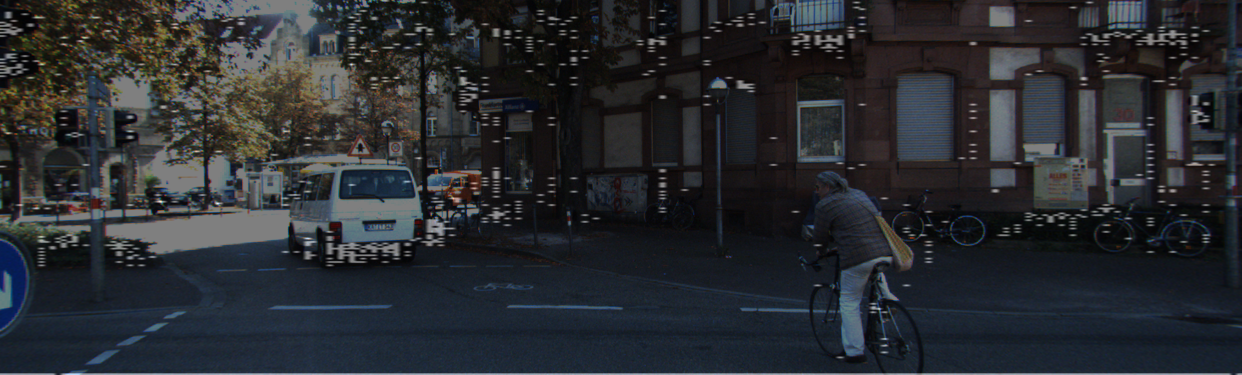

In [82]:
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [51]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [52]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [83]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

TypeError: ignored

뭔가 결과가 이상해서 수정하는 중입니다